# Optimization of Fermion-to-Qubit Mappings via Simulated Annealing on Majorana Operator Pools

#### Team Members: Thierry Kaldenbach, Marc Maußner, Oneka Singh, Filip-Ioan Ceară, Cristian Ilie

## Introduction

One of the most promising prospects of quantum computation naturally lies in the simulation of quantum mechanical systems themselves. In our work, we focus on the subclass of fermionic systems. While in many instances of problems, the task of transpiling quantum circuits to a specific hardware boils down to finding a good mapping from virtual to physical qubits, the optimization of fermionic circuits offers more degrees of freedom, that is the fermion-to-qubit mapping itself. In fact, the number of possible fermion-to-qubit mappings already scales exponentially in the number of fermionic modes even when one chooses the simplest kind of representation of Majoranas in terms of Pauli strings, i.e. each Majorana is represented by a single string. 

The zoo of known studied fermionic mappings is pretty large, so we mostly compare to the two most prominent instances in our work - the Jordan-Wigner (JW)- and the Bravyi-Kitaev (BK) transformation/mapping.

The JW mapping is known to suffer from $\mathcal{O}(N)$ scaling of Pauli weights, introducing a large swapping overhead on limited-connectivity devices. The BK mapping elegantly addresses this issue and provides $\mathcal{O}(\log N)$ scaling of Pauli weights instead. And while this looks promising on paper, this advantage is typically mitigated or destroyed when mapping the problem to an actual hardware.

A big advantage of both mappings is that they can be deterministically and efficiently constructed. In our project, we use these mappings as starting points for non-deterministic optimization schemes based on simulated annealing. Therefore, our approach profits from a good initial guess in case of the BK mapping.


## Idea

Again, our main focus lies on the optimization of the fermion-to-qubit mapping. In practice, this mapping then comes into place for the initial state, variational quantum circuit, and the observable (e.g. Hamiltonian). We provide a short schematic below:

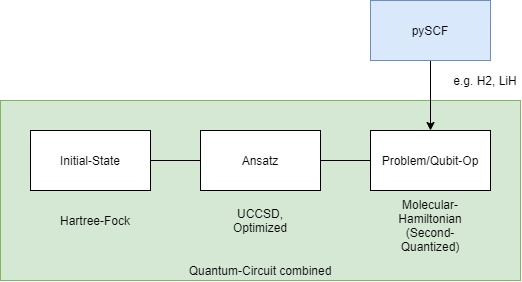

In the first stage we try to do this hardware agnostic.

First, we have to carefully establish the idea of what actually makes a fermion-to-qubit mapping good. For that purpose, we recapture the electronic structure Hamiltonian, which we express in terms of fermionic creation/annihilation operators or Majorana operators below. 

- With Creation/Annihiliation Operators:
$$
  H_{f} =  \sum \limits _{ij} ^{N-1}h_{ij}{a_{i}^\dagger}a_{j} + \sum \limits _{ijkl}^{N-1}h_{ijkl}{a_{i}^\dagger}{a_{j}^\dagger}a_{k}a_{l}
$$
- With Majorana Operators:
$$
  H_{f} =  \sum \limits _{ij} ^{2N-1}ic_{ij}m_{i}m_{j} + \sum \limits _{ijkl} ^{2N-1}c_{ijkl}m_{i}m_{j}m_{k}m_{l}
$$

It is crucial to know the anticommutation properties of the Majorana operators, namely:
$$
  \{m_i, m_j\} = 2\delta_{ij}
$$

Note that the Hamiltonian is always separated into a quadratic and a quartic part. Owed to the adiabatic theorem, one could interpret most state preparations in quantum chemistry as a trotterized time evolution of this Hamiltonian. Therefore, to obtain efficient circuits for quantum chemistry (e.g., Unitary Coupled Cluster Theory (UCC)), one wants to minimize the circuit cost of the Trotterized time evolution. That boils down to minimizing the average Pauli weights across all the quartic and quadratic terms. And since the computational complexity is typically dominated by the quartic terms, one mainly wants to minimize their average weight, which is hard due to the $\mathcal{O}(N^4)$ number of terms.

Since the Majorana operators $m_j$ are known for the JW- and BK mapping, we have a straightforward way to obtain a set of $2N$ mutually anticommuting Pauli strings. By picking any of these Majorana strings, and multiplying all the other strings with it, we obtain a new set of mutually anticommuting Pauli strings, and therefore a new valid fermion-to-qubit mapping. For this mapping, we evaluate our cost function based on the weights of the quadratic and quartic operators, and decide whether we have achieved a better mapping. For that purpose, we employ the simulated annealing algorithm, more details on that later. 


We will later see that our approach permits us to achieve improvements over the BK mapping, which is already considered to be asymptotically optimal. We want to further emphasize that while our approach works quite fast, it is not really runtime-critical since a mapping only has to be generated once, and then it can be used for all sorts of problems of the appropriate size. 

While we optimize our mappings assuming all-to-all connectivity, we see that their advantages over other mappings remain or become even more pronounced when transpiling for limited connectivity. 

In the following, we show a schematic of our project plan for this hackathon.

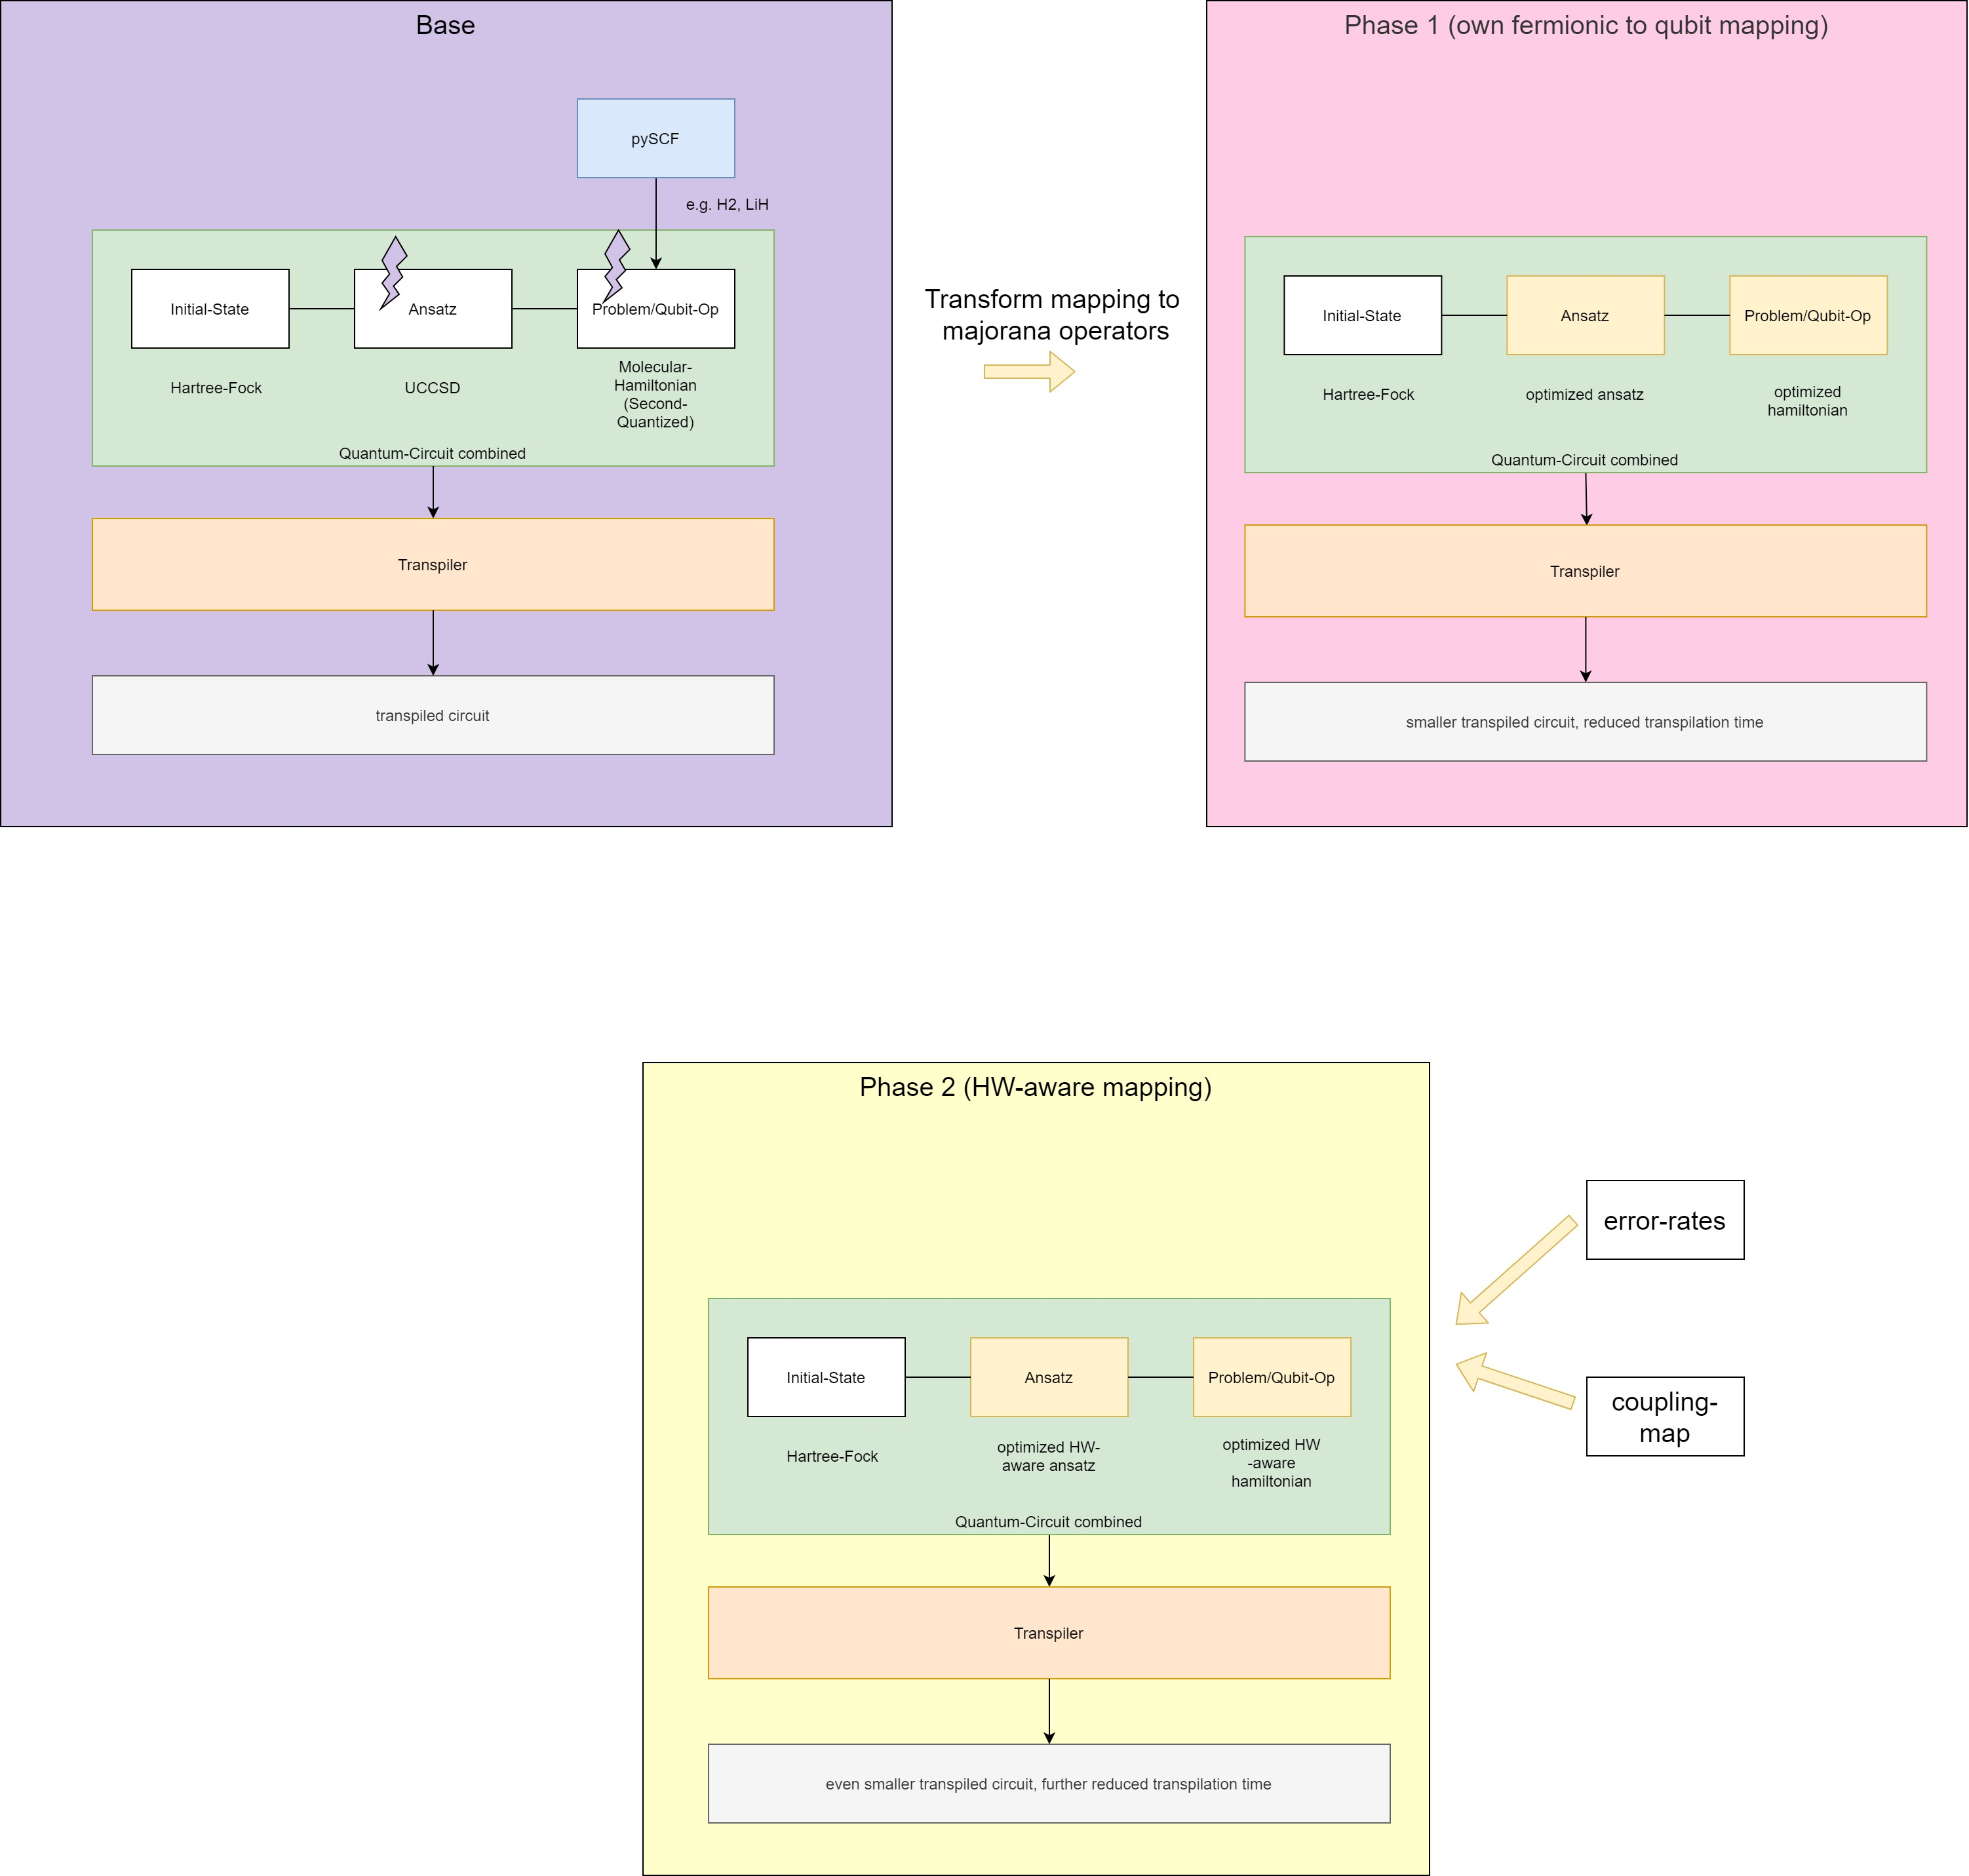

### Imports

In [49]:
%load_ext autoreload
%autoreload 2

from fermionic_mappings import jw_majoranas, bk_majoranas
from electronic_hamiltonian import quadratic_terms, quartic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
from cost_functions import weight, quadratic_term_mean_weight, quartic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create Majorana Strings using Jordan-Wigner-Mapping or Bravyi-Kitaev-Mapping

Here, we just provide a super basic example on how to obtain the Majorana Pauli strings. One can use this code snipping for both the JW- and BK mapping.

In [57]:
N = 20

x, z = jw_majoranas(N)
# x, z, paulis = bk_majoranas(N)

paulis = PauliList.from_symplectic(z, x)

print("Majorana Operators:", paulis)

Majorana Operators: ['IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXZ', 'IIIIIIIIIIIIIIIIIXZZ',
 'IIIIIIIIIIIIIIIIXZZZ', 'IIIIIIIIIIIIIIIXZZZZ', 'IIIIIIIIIIIIIIXZZZZZ',
 'IIIIIIIIIIIIIXZZZZZZ', 'IIIIIIIIIIIIXZZZZZZZ', 'IIIIIIIIIIIXZZZZZZZZ',
 'IIIIIIIIIIXZZZZZZZZZ', 'IIIIIIIIIXZZZZZZZZZZ', 'IIIIIIIIXZZZZZZZZZZZ',
 'IIIIIIIXZZZZZZZZZZZZ', 'IIIIIIXZZZZZZZZZZZZZ', 'IIIIIXZZZZZZZZZZZZZZ',
 'IIIIXZZZZZZZZZZZZZZZ', 'IIIXZZZZZZZZZZZZZZZZ', 'IIXZZZZZZZZZZZZZZZZZ',
 'IXZZZZZZZZZZZZZZZZZZ', 'XZZZZZZZZZZZZZZZZZZZ', 'IIIIIIIIIIIIIIIIIIIY',
 'IIIIIIIIIIIIIIIIIIYZ', 'IIIIIIIIIIIIIIIIIYZZ', 'IIIIIIIIIIIIIIIIYZZZ',
 'IIIIIIIIIIIIIIIYZZZZ', 'IIIIIIIIIIIIIIYZZZZZ', 'IIIIIIIIIIIIIYZZZZZZ',
 'IIIIIIIIIIIIYZZZZZZZ', 'IIIIIIIIIIIYZZZZZZZZ', 'IIIIIIIIIIYZZZZZZZZZ',
 'IIIIIIIIIYZZZZZZZZZZ', 'IIIIIIIIYZZZZZZZZZZZ', 'IIIIIIIYZZZZZZZZZZZZ',
 'IIIIIIYZZZZZZZZZZZZZ', 'IIIIIYZZZZZZZZZZZZZZ', 'IIIIYZZZZZZZZZZZZZZZ',
 'IIIYZZZZZZZZZZZZZZZZ', 'IIYZZZZZZZZZZZZZZZZZ', 'IYZZZZZZZZZZZZZZZZZZ',
 'YZZZZZZZZZZZZZZZZZZZ']


### (Optional) Compute all possible quadratic and quartic terms

Here, we brute-force generate the Pauli string representations of all the potential Hamiltonian terms. Again, this is just to give an overview.

In [29]:
x_terms, z_terms = quadratic_terms(x, z, N)
quadratic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quadratic Hamiltonian Terms:", quadratic_terms_paulis)

x_terms, z_terms = quartic_terms(x, z, N)
quartic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quartic Hamiltonian Terms:", quartic_terms_paulis)

print(f"Average Weight: {weight(x, z)}")

Quadratic Hamiltonian Terms: ['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIY',
 'IIIIIIIIIIIIIIIIIIIIIIIZX', 'IIIIIIIIIIIIIIIIIIIIIIXYX',
 'IIIIIIIIIIIIIIIIIIIIIIYYX', 'IIIIIIIIIIIIIIIIIIIIIIZYX',
 'IIIIIIIIIIIIIIIIIIIIIZIXX', 'IIIIIIIIIIIIIIIIIIIXXYIXX',
 'IIIIIIIIIIIIIIIIIIIXYYIXX', 'IIIIIIIIIIIIIIIIIIIXZYIXX',
 'IIIIIIIIIIIIIIIIIIIYIYIXX', 'IIIIIIIIIIIIIIIIIIXZIYIXX',
 'IIIIIIIIIIIIIIIIIIYZIYIXX', 'IIIIIIIIIIIIIIIIIIZZIYIXX',
 'IIIIIIIIIIIIIIIIIZIIIXIXX', 'IIIIIIIIIIIIIXIXXYIIIXIXX',
 'IIIIIIIIIIIIIXIXYYIIIXIXX', 'IIIIIIIIIIIIIXIXZYIIIXIXX',
 'IIIIIIIIIIIIIXIYIYIIIXIXX', 'IIIIIIIIIIIIIXXZIYIIIXIXX',
 'IIIIIIIIIIIIIXYZIYIIIXIXX', 'IIIIIIIIIIIIIXZZIYIIIXIXX',
 'IIIIIIIIIIIIIYIIIYIIIXIXX', 'IIIIIIIIIIIXXZIIIYIIIXIXX',
 'IIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIZY',
 'IIIIIIIIIIIIIIIIIIIIIIXYY', 'IIIIIIIIIIIIIIIIIIIIIIYYY',
 'IIIIIIIIIIIIIIIIIIIIIIZYY', 'IIIIIIIIIIIIIIIIIIIIIZIXY',
 'IIIIIIIIIIIIIIIIIIIXXYIXY', 'IIIIIIIIIIIIIIIIIIIXYYIXY',
 'IIIIIIIIIIIIIIIIIIIXZYIXY

### Optimizing Fermionic Mappings with Simulated Annealing

To assess the quality of a fermionic mapping, we compute the average cost to implement any quartic or quadratic fermionic terms on a quantum computer. Assuming all-to-all connectivity for the sake of simplicity, this optimization tasks simply boils down to minimizing the average weight/locality of the strings associated with the fermionic operators.

For an $N$ mode system, based on a set of $2N$ mutually anti-commuting Pauli strings, one can straightforwardly define a "neighborhood" of fermionic. Elements from this neighborhood are attained by applying a specific rule to the Majorana strings. More explicitly, assuming some solution with strings $P_1, P_2, \dots, P_{2N}$, one can pick any string $P_j$ and multiply all other strings with it, therefore $P_i \to P_i P_j$ for $i \neq j$. One can easily verify that this rule preserves of structure of the underlying anticommutation graph, and therefore provides another valid fermion-to-qubit mapping. We use this rule as an exploration strategy in the annealer (in our code its called "spread_node"). 

As a cost/energy function, we use the average Pauli weight of the quadratic fermionic terms $m_i m_j$. Note that previously, we explained that one should focus on the weight of the $m_i m_j m_k m_l$, however that is not scalable as its $\mathcal{O}(N^4)$. Fortunately, we figured that optimizing for the $m_i m_j$ also leads close-to-optimal solutions for the quartic terms, and scales more favorably with $\mathcal{O}(N^2)$. We will see the justification of this approximation in a second. But first, we finish describing the optimization algorithm.

In detail, this works as follows:

1. Start from the Majorana Pauli strings from a known fermionic mapping. 
2. Run simulated annealing with the exploration strategy and cost function described above. We use a starting temperature $\mathcal{O}(\log(N))$ and an exponential cooling scheme. 

### Justification of the approximative cost function

We now compare two optimization schemes to highlight. First, we run annealing this the $\mathcal{O}(N^4)$ cost function, which is slow. 

Then we reset the initial guess (start over from JW) and optimize with the $\mathcal{O}(N^2)$ cost function instead. We now take this result, plug into another annealer with the $\mathcal{O}(N^4)$ cost function. We find that this does not significantly improve the solution, therefore, we can simply stick to the more efficient cost functions.

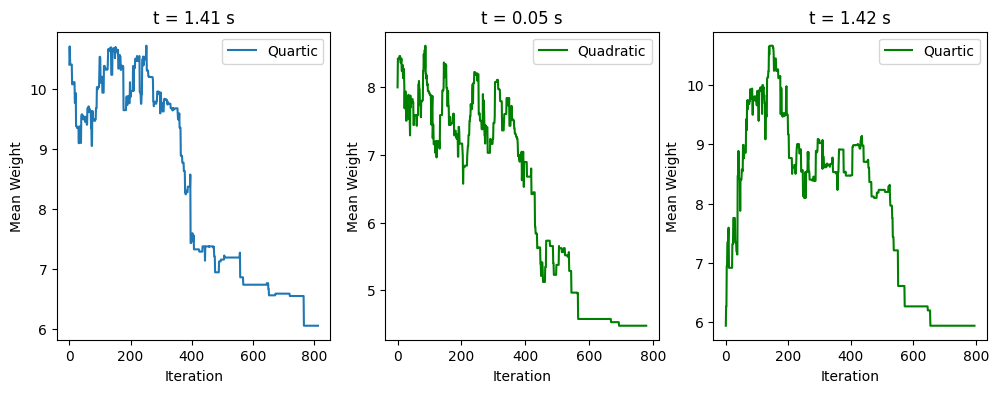

In [ ]:
cooling_rate = 0.9995
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Run the optimization with the quartic (expensive) cost function
start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quartic_term_mean_weight, cooling_rate=cooling_rate)
end = time.time()
elapsed_seconds = end - start

axs[0].plot(energies, label="Quartic")
axs[0].set_title(f"t = {elapsed_seconds:.2f} s")

# Reset to the JW strings and instead first run a cheaper quadratic optimization
x, z = jw_majoranas(N)

start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=cooling_rate)   
end = time.time()
elapsed_seconds = end - start

axs[1].plot(energies, label="Quadratic", color="green")
axs[1].set_title(f"t = {elapsed_seconds:.2f} s")

# Use the result from the quadratic optimization as an input for the more expensive quartic optimization
start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quartic_term_mean_weight, cooling_rate=cooling_rate)
end = time.time()
elapsed_seconds = end - start

axs[2].plot(energies, label="Quartic", color="green")
axs[2].set_title(f"t = {elapsed_seconds:.2f} s")

for ax in axs:
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mean Weight")
    ax.legend()

From the figure above, we see that quadratic optimization finds the same solution in a fraction of time. 

This provides us with a scalable optimizer we can employ on hundreds of qubits! We now demonstrate this.

### Locality Analysis starting from JW mapping

Here, we consider the JW mapping for various problem sizes up to 160 qubits. For each instance, we run our simulated annealing protocol and optimize w.r.t. the average weight of quadratic terms. Based on the optimized results, we recover the average weight of quartic terms, as motivated in the previous section. 

In [ ]:
### YOU DONT HAVE TO EXECUTE THIS CELL. THE RESULTS ARE STORED BELOW!

quadratic_weights = []
quartic_weights = []

quadratic_weights_jw = []
quartic_weights_jw = []

num_qubits = list(range(10, 161, 10))

for N in num_qubits:

    x, z = jw_majoranas(N)
    # Compute the Weights for the JW mapping (starting point)
    quadratic_weights_jw.append(quadratic_term_mean_weight(x, z))
    quartic_weights_jw.append(quartic_term_mean_weight(x, z))

    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9995)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

In [ ]:
### Storing the results here for the optimizations based on JW to avoid running the cell above every time

num_qubits = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]

quadratic_weights_jw = np.array([4.666666666666667, 8.0, 11.333333333333334, 14.666666666666666, 18.0, 21.333333333333332, 24.666666666666668, 28.0, 31.333333333333332, 34.666666666666664, 38.0, 41.333333333333336, 44.666666666666664, 48.0, 51.333333333333336, 54.666666666666664])
quartic_weights_jw = np.array([6.4, 10.4, 14.4, 18.4, 22.4, 26.4, 30.4, 34.4, 38.4, 42.4, 46.4, 50.4, 54.4, 58.4, 62.4, 66.4])

quadratic_weights = np.array([2.688888888888889, 4.473684210526316, 6.149425287356322, 7.82051282051282, 9.489795918367347, 11.158192090395481, 12.826086956521738, 14.518670886075949, 16.194007490636704, 17.87757575757576, 19.54095079232694, 21.351960784313725, 23.044722719141323, 24.697225077081193, 26.215928411633108, 28.083490566037735])
quartic_weights = np.array([3.5238095238095237, 5.943034055727554, 8.030140485312899, 10.073180873180872, 12.098827616152844, 14.115848944394886, 16.1279688513952, 18.187037645898407, 20.208548875034733, 22.245547246077436, 24.24570007716711, 26.528682207346215, 28.563445339681376, 30.543116705801157, 32.26899230143717, 34.66383368904967])

Next, we visualize the average weights of the mappings obtained from the optimization.

Text(0, 0.5, 'Mean Weight Ratio (OPT/JW)')

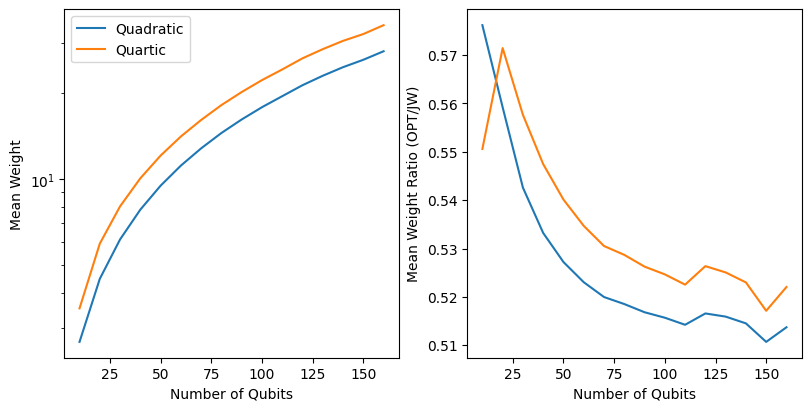

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

axs[0].plot(num_qubits, quadratic_weights, label="Quadratic")
axs[0].plot(num_qubits, quartic_weights, label="Quartic")
axs[0].set_xlabel("Number of Qubits")
axs[0].set_ylabel("Mean Weight")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(num_qubits, quadratic_weights/quadratic_weights_jw, label="Quadratic")
axs[1].plot(num_qubits, quartic_weights/quartic_weights_jw, label="Quartic")
axs[1].set_xlabel("Number of Qubits")
axs[1].set_ylabel("Mean Weight Ratio (OPT/JW)")
# axs[1].legend()

On the left side, we find that the weight of the optimized mappings seems to scale asymptotically logarithmically, which is plausible given that a logarithmic mapping exists in the form of BK. On the right side, we simply compare the cost ratios.

This observation leads to a more sophisticated approach: Instead of starting our optimization based on the Majorana strings of the JW mapping, we immediately depart from the more resource-efficient BK mapping.

### Locality Analysis starting from BK mapping

We now repeat the same analysis, but instead start from the BK mapping. 

In [ ]:
### YOU DONT HAVE TO EXECUTE THIS CELL. THE RESULTS ARE STORED BELOW!

quadratic_weights = []
quartic_weights = []

quadratic_weights_bk = []
quartic_weights_bk = []

num_qubits = list(range(10, 101, 5))

for N in num_qubits:

    print(N)

    x, z, _ = bk_majoranas(N)

    quadratic_weights_bk.append(quadratic_term_mean_weight(x, z))
    quartic_weights_bk.append(quartic_term_mean_weight(x, z))

    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9999)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

In [85]:
### Storing the results here for the optimizations based on BK to avoid running the cell above every time

num_qubits = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

quadratic_weights_bk = [3.111111111111111, 3.4380952380952383, 4.368421052631579, 4.72, 4.905747126436782, 5.470588235294118, 5.87948717948718, 6.177777777777778, 6.32734693877551, 6.48956228956229, 6.526553672316385, 6.6625, 7.118426501035197, 7.414414414414415, 7.570253164556962, 7.773669467787115, 7.89063670411985, 7.980515117581187, 8.058787878787879]
quartic_weights_bk = [4.276190476190476, 4.672527472527473, 6.355830753353973, 6.839525691699604, 7.217588031381135, 8.432085561497326, 8.951504540978226, 9.35481056411289, 9.651046461137646, 9.959818797554647, 10.092261630112686, 10.459704005671748, 11.35812279486746, 11.816953391747912, 11.97388307894637, 12.31131996730517, 12.460217048438668, 12.552221501502256, 12.78760463885648]

quadratic_weights = [2.7555555555555555, 3.419047619047619, 3.8947368421052633, 4.48, 4.793103448275862, 4.99327731092437, 5.351282051282051, 5.715151515151515, 6.0253061224489795, 6.214814814814815, 6.388700564971751, 6.506730769230769, 6.5950310559006216, 6.785945945945946, 7.030063291139241, 7.20952380952381, 7.414481897627965, 7.60515117581187, 7.753939393939394]
quartic_weights = [3.742857142857143, 4.863003663003663, 5.786171310629515, 6.73897233201581, 7.210509031198686, 7.614438502673797, 8.36931830616041, 9.0547065337763, 9.445175857577073, 9.643846300450074, 9.943211623447866, 10.230464965142385, 10.48035162150519, 10.92169649101156, 11.38463751438435, 11.742288687440888, 12.129548878948336, 12.40121122836335, 12.487079420334206]

0.041244069872592326


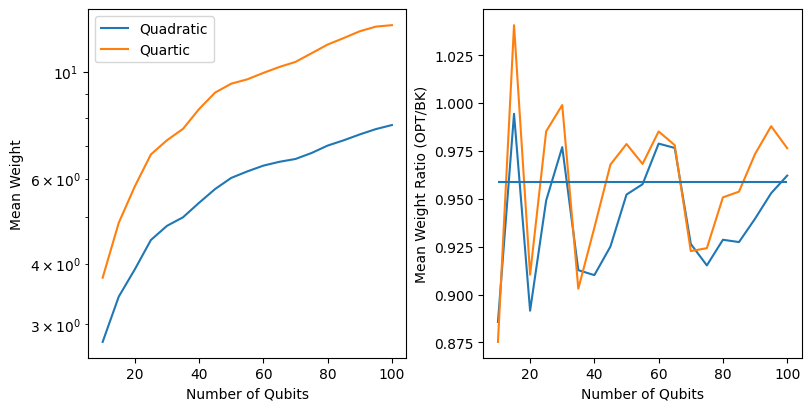

In [93]:
quadratic_weights = np.array(quadratic_weights)
quartic_weights = np.array(quartic_weights)

quadratic_weights_bk = np.array(quadratic_weights_bk)
quartic_weights_bk = np.array(quartic_weights_bk)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

axs[0].plot(num_qubits, quadratic_weights, label="Quadratic")
axs[0].plot(num_qubits, quartic_weights, label="Quartic")
axs[0].set_xlabel("Number of Qubits")
axs[0].set_ylabel("Mean Weight")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(num_qubits, quadratic_weights/quadratic_weights_bk, label="Quadratic")
axs[1].plot(num_qubits, quartic_weights/quartic_weights_bk, label="Quartic")
axs[1].set_xlabel("Number of Qubits")
axs[1].set_ylabel("Mean Weight Ratio (OPT/BK)")

mean = np.mean(quartic_weights/quartic_weights_bk)

axs[1].hlines(y=mean, xmin=num_qubits[0], xmax=num_qubits[-1])
# axs[1].legend()
print(1-mean)

Unsurprisingly, we find a very similar behavior to the BK mapping, given that this was our initial guess for the optimizer. What is however remarkable here is that there seems to be a constant improved over the BK mapping by about 4%. Given that the BK mapping is already extremely good w.r.t. to the Pauli weights, this is a major result!

Now having established that we can efficiently employ simulated annealing to come up with new fermionic mappings which exceed the efficiency of BK, we now move on to some practical examples. 

------------------------------

## "Naive"/default solution and benchmarking of our mapping

In [1]:
# imports
from __future__ import annotations

from functools import lru_cache

import numpy as np

from qiskit.quantum_info.operators import Pauli

from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from qiskit_algorithms import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import time

In [2]:
# imports for majorana mapping calculation
%load_ext autoreload
%autoreload 2

from fermionic_mappings import bk_majoranas
from electronic_hamiltonian import quadratic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
import random
from cost_functions import weight, quadratic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt

### Define problem with ansatz

In the following, we consider some small molecules which are used as common benchmarks for quantum chemistry.

In [3]:
driver_h2o = PySCFDriver(atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0", basis="sto-3g")
problem_h2o = driver_h2o.run()

driver_lih = PySCFDriver(atom="Li 0 0 0; H 0 0 1.5", basis="sto-3g")
problem_lih = driver_lih.run()

driver_h2 = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem_h2 = driver_h2.run()

### Build MajoranaMapper

Here, we define our own fermionic mapper class which then seemlessly integrates into Qiskit nature, to use our newly generated fermionic mappings for unitary coupled cluster simulations. 

In [4]:
"""The Majorana Mapper. """
n = 0
def set_n(new_n):
    global n 
    n = new_n

def obtain_n():
    return n
    

class MajoranaMapper(FermionicMapper):
    """The Majorana fermion-to-qubit mapping."""
    
    @classmethod
    @lru_cache(maxsize=32)
    def pauli_table(cls, register_length: int) -> list[tuple[Pauli, Pauli]]:
        # pylint: disable=unused-argument
        pauli_table = []

        N = obtain_n()
        print("Num qubits: ", N)

        # obtain majorana paulis for problem instance
        x, z ,_= bk_majoranas(N)
            
        x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.99995)

        paulis = PauliList.from_symplectic(z, x)
        #print(paulis)
        
        for i in range(int(len(paulis)//2)):
            pauli_table.append((paulis[i], paulis[int(len(paulis)//2+i)]))

        #print(pauli_table)

        # PauliList has the phase information.
        # Here, phase is unnecessary, so the following removes phase.
        for pauli1, pauli2 in pauli_table:
            pauli1.phase = 0
            pauli2.phase = 0
        return pauli_table

### Add Mapping

Here, we define the mappings to be benchmarked.

In [5]:
mappers = {}
mappers["JW"] = JordanWignerMapper()
#mappers["Parity"] = ParityMapper()
mappers["Bravi-Kitaev"] = BravyiKitaevMapper()
mappers["Majorana"] = MajoranaMapper()

### Create ansatz and transpile to ibm_torino

Here, we access the FakeBackend to provide us with the connectivity and gateset of a real quantum device (ibm_torino). 

In [ ]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="xyz", set_as_default=True, overwrite=True)
service = QiskitRuntimeService()
# We define a specific backend
from qiskit_ibm_runtime.fake_provider import FakeTorino
#torino_backend = service.backend("ibm_torino")
torino_backend = FakeTorino()
seed = 43

/var/folders/cp/l_nj7m8d1vbcnqdgjq_mg5_80000gn/T/ipykernel_38190/2925123764.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


This function provides the resource estimates for a UCCSD circuit given a problem (molecule). These estimates include the count_ops, size (number of gates), and the actual circuit depth before and after transpilation. We consider these estimates for each of the mappers defined above.

In [7]:
def obtain_resources(problem):   
    for key in mappers.keys():
        print(f"Generating ansatz and transpiled ansatz for: {key}")
        if key == "Majorana":
            set_n(2*problem.num_spatial_orbitals)

        qubit_op = mappers[key].map(problem.second_q_ops()[0])
    
        ansatz = UCCSD(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mappers[key],
            initial_state=HartreeFock(
                problem.num_spatial_orbitals,
                problem.num_particles,
                mappers[key],
            ),
        )

        print(f"\tANSATZ: Count-Ops: {ansatz.decompose().decompose().decompose().count_ops()} size: {ansatz.decompose().decompose().decompose().size()} depth = {ansatz.decompose().decompose().decompose().depth()}")

        # transpile ansatz
        pm = generate_preset_pass_manager(
            backend=torino_backend,
            optimization_level=3,
            seed_transpiler=seed,
            layout_method="sabre",
        )

        start = time.time()
        circuit_opt = pm.run(ansatz)
        end = time.time()
        elapsed_seconds = end - start
        circuit_opt.draw("mpl", fold=False, idle_wires=False)
        print(f"\tANSATZ transpilation took: {elapsed_seconds:.2f}")
        print(f"\tANSATZ transpiled: Count-Ops: {circuit_opt.decompose().decompose().decompose().count_ops()} size: {circuit_opt.decompose().decompose().decompose().size()} depth = {circuit_opt.decompose().decompose().decompose().depth()}\n\n")

Compute the results.

### H2

In [8]:
# proof of concept
obtain_resources(problem_h2)

Generating ansatz and transpiled ansatz for: JW
	ANSATZ: Count-Ops: OrderedDict({'h': 80, 'cx': 56, 'sdg': 20, 's': 20, 'rz': 12, 'u': 2}) size: 190 depth = 97
	ANSATZ transpilation took: 0.09
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 271, 'u': 97, 'cx': 41}) size: 409 depth = 304


Generating ansatz and transpiled ansatz for: Bravi-Kitaev
	ANSATZ: Count-Ops: OrderedDict({'cx': 38, 'h': 36, 'sdg': 10, 'rz': 10, 's': 10, 'u': 3, 'ry': 2}) size: 109 depth = 77
	ANSATZ transpilation took: 0.14
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 273, 'u': 85, 'cx': 39}) size: 397 depth = 315


Generating ansatz and transpiled ansatz for: Majorana
Num qubits:  4
	ANSATZ: Count-Ops: OrderedDict({'cx': 34, 'h': 28, 'rz': 9, 'sdg': 4, 's': 4, 'u': 1, 'rzz': 1, 'rzx': 1, 'rx': 1}) size: 83 depth = 55
	ANSATZ transpilation took: 0.20
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 254, 'u': 77, 'cx': 40}) size: 371 depth = 278




Given that our optimizations start from the BK mapping, we use this as a reference. We find that for the circuit size, we can decrease the gate count from 109 to 83, which is a 24% reduction. At the same time, we achieve a depth reduction from 77 to 55, which is 29%. 

### H2O

In [9]:
obtain_resources(problem_h2o)

Generating ansatz and transpiled ansatz for: JW
	ANSATZ: Count-Ops: OrderedDict({'cx': 14360, 'h': 7840, 'sdg': 1960, 's': 1960, 'rz': 1000, 'u': 10}) size: 27130 depth = 18014
	ANSATZ transpilation took: 42.23
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 91821, 'u': 18340, 'cx': 14838}) size: 124999 depth = 90422


Generating ansatz and transpiled ansatz for: Bravi-Kitaev
	ANSATZ: Count-Ops: OrderedDict({'cx': 13108, 'h': 11122, 'sdg': 2889, 's': 2889, 'rz': 999, 'u': 6, 'ry': 1}) size: 31014 depth = 16849
	ANSATZ transpilation took: 30.90
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 126355, 'u': 19944, 'cx': 18338}) size: 164637 depth = 107763


Generating ansatz and transpiled ansatz for: Majorana
Num qubits:  14
	ANSATZ: Count-Ops: OrderedDict({'cx': 11432, 'h': 9034, 'sdg': 2169, 's': 2169, 'rz': 994, 'u': 2, 'ry': 2, 'rx': 1, 'rzx': 1, 'rxx': 1, 'ryy': 1}) size: 25806 depth = 13752
	ANSATZ transpilation took: 28.72
	ANSATZ transpiled: Count-Ops: OrderedDict({'u3': 16861

We find that for the circuit size, we can decrease the gate count from 31014 to 25806, which is a 17% reduction. At the same time, we achieve a depth reduction from 16849 to 13752, which is 18%. 

### LiH

In [9]:
obtain_resources(problem_lih)

Generating ansatz and transpiled ansatz for: JW
	ANSATZ: Count-Ops: OrderedDict([('cx', 8064), ('h', 4992), ('sdg', 1248), ('s', 1248), ('rz', 640), ('u', 4)]) size: 16196 depth = 10315
	ANSATZ transpilation took: 26.02
	ANSATZ transpiled: Count-Ops: OrderedDict([('u3', 40623), ('u', 9643), ('cx', 7134)]) size: 57400 depth = 43343


Generating ansatz and transpiled ansatz for: Bravi-Kitaev
	ANSATZ: Count-Ops: OrderedDict([('cx', 8680), ('h', 7440), ('sdg', 1670), ('s', 1670), ('rz', 640), ('u', 2)]) size: 20102 depth = 11043
	ANSATZ transpilation took: 35.32
	ANSATZ transpiled: Count-Ops: OrderedDict([('u3', 75662), ('u', 12922), ('cx', 10828)]) size: 99412 depth = 66261


Generating ansatz and transpiled ansatz for: Majorana
Num qubits:  12
	ANSATZ: Count-Ops: OrderedDict([('cx', 7122), ('h', 5558), ('sdg', 1393), ('s', 1393), ('rz', 638), ('u', 4), ('ry', 1), ('rxx', 1)]) size: 16110 depth = 8731
	ANSATZ transpilation took: 47.83
	ANSATZ transpiled: Count-Ops: OrderedDict([('u3', 981

We find that for the circuit size, we can decrease the gate count from 20102 to 16110, which is a 20% reduction. At the same time, we achieve a depth reduction from 11043 to 8731, which is 20%. 

## Results

We find that for all the molecules under consideration, our custom mappings reduce both the gate count and circuit depth by about 20%. 

## Conclusion

In this project, we have introduced a novel and scalable workflow to design new fermionic mappings based on simulated annealing optimization of Majoranic pools. In a more abstract setting aiming to minimize the average Pauli weight of arbitary electronic Hamiltonians, we find that we can outperform the BK mapping by about 4%. It is worth mentioning that our algorithm scales well beyond 100 qubits, enabling to design mappings for utility-scale experiments. 

Based on our results for UCCSD circuits, we can claim that this improvement becomes even more significant when one applies our mapping to a real problem. This is different from the approach above in a sense that not all possible fermionic terms play a role, but rather only problem-specific ones (the single- and double excitations).

Even without running noisy simulations, it is obvious that our results are superior in a noisy setting given that both the gate count and circuit depth are improved.

Finally, it is worth highlighting that full-connectivity hardware exists, to which our approach can be seemlessly applied without any further tweaks! 

## Challenges

Within the scope of this project, we have not had time to further tailor our mappings towards specific architectures. One can infer from the results for the molecules that our mappings are prone gate blow-ups induces by hardware constraints. This is a commonly known problem.

For the future, we suggest adjusting our annealing protocol to use a cost function, which evaluates the average weights of operators w.r.t. to the target hardware instead of full connectivity. Also, one could utilize distance map to incorporate physical gate errors and not only the distance on the chip. 

## Outlook 

We have started doing some investigations on hardware-aware mappings. However, we decided not to include this into the main project since the work is unfinished. You can see the preliminary work in the transpilation juypter notebook.

## References

On anticommutation graphs of Pauli strings:

- [ACEB24] Gerard Aguilar, Simon Cichy, Jens Eisert, and Lennart Bittel. Full classification of pauli
lie algebras, 2024.

On the binary representation of Pauli strings we use internally:

- [AG04] Scott Aaronson and Daniel Gottesman. Improved simulation of stabilizer circuits. Phys.
Rev. A, 70:052328, Nov 2004.

Some cool references about hardware-aware fermionic mappings:

- [MGZ24] Aaron Miller, Adam Glos, and Zoltan Zimboras. Treespilation: Architecture- and stateoptimised
fermion-to-qubit mappings, 2024.

- [MZK+23] Aaron Miller, Zoltan Zimboras, Stefan Knecht, Sabrina Maniscalco, and Guillermo Garcıa-
Perez. Bonsai algorithm: Grow your own fermion-to-qubit mappings. PRX Quantum,
4:030314, Aug 2023.

The BK mapping:

- [SRL12] Jacob T. Seeley, Martin J. Richard, and Peter J. Love. The bravyi-kitaev transformation for
quantum computation of electronic structure. The Journal of Chemical Physics, 137(22),
December 2012.